In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt
import glob

In [2]:
ls_df = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Combined_GA_VA/GAVA_LANDSAT.csv')
elev_df = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Combined_GA_VA/gava_dm_gm_elev.csv')

In [8]:
ls_df['Year'] = ls_df['LS_year']

In [18]:
df0 = pd.merge(ls_df, elev_df, on = ['Plant_Biomass', 'Latitude', 'Longitude', 'Year'], how = 'left',
              suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

df0


# Apply z-star transformation
df0['z_star'] = np.where(
    df0['Latitude'] >= 35,
    (df0['elevation'] - (-0.106)) / (0.569 - (-0.106)),  # formula for >= 35
    (df0['elevation'] - (-0.071)) / (0.569 - (-0.071))   # formula for < 35
)

In [35]:
##EXPORT
out_dir = os.path.expanduser('~/Downloads')
out_csv = os.path.join(out_dir, 'gava_final.csv')
# df0.to_csv(out_csv, index = False)

In [19]:
from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from datetime import datetime

yargs=df0['Plant_Biomass'] 


xargs = df0[['nd_swir2_nir_median_05_10','z_star','nd_swir2_nir_mean_05_10', 'Percent_flooding','srad_peak','evi_mean_08_10',
            'evi_max_05_10','nd_g_b_mean_01_12','evi_max_01_12','nd_swir2_nir_median_08_10','nd_swir2_r_min_05_10',
            'evi_mean_01_12','nd_g_b_median_01_12','Blue_band_max_05_10','nd_swir2_nir_median_01_12',
            'Red_band_max_05_10','dayl_daymMarMay','eddi2y','nd_swir2_nir_min_05_10','savi_mean_01_12',
            'slope']] #TOOK ELEV OUT, ADDED Z_STAR

##Removed:
''''elevation
                ''' 

size_x = 0.2
seed = 3
xargs_train, xargs_test, yargs_train, yargs_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed) 
## 80% training and 20% test


'''LOG transform the river discharge data, and also calculate z scores'''

'LOG transform the river discharge data, and also calculate z scores'

In [36]:
#Pipeline:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn import metrics

#Hyperparameters tuned later
pipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=300, 
                                                                                min_samples_split=5, 
                                                                                min_samples_leaf=2,
                                                                                max_depth=None, random_state=seed))])
'''
CodeEditor version:
pipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=1000, 
                                                                                min_samples_split=5, 
                                                                                min_samples_leaf=1,
                                                                                max_depth=200, random_state=seed))])
'''

# ##DEFAULTS:
# pipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=100, 
#                                                                                 min_samples_split=2, 
#                                                                                 min_samples_leaf=1,
#                                                                                 max_depth=None, random_state=seed))])
pipe.fit(xargs_train, yargs_train)
y_pred=pipe.predict(xargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yargs_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred)))
r_square = metrics.r2_score(yargs_test, y_pred)
print("The r squared is: " + str(r_square))
print(r_square)
print('testing r2 is: ' + str(pipe.score(xargs_test, yargs_test)))
print('training r2 is: ' + str(pipe.score(xargs_train, yargs_train)))
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(yargs_test, y_pred))/np.ptp(yargs_test)))

# Mean
print('MEAN BASELINE:')
y_pred_mean = [np.mean(yargs_train)] * len(yargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred_mean))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred_mean)))

# NDVI
print('NDVI BASELINE: around 0.2 r sq, RMSE 650')

Mean Absolute Error: 283.172126659443
Mean Squared Error: 161611.82911339056
Root Mean Squared Error: 402.0097375852861
The r squared is: 0.5402368613516452
0.5402368613516452
testing r2 is: 0.5402368613516452
training r2 is: 0.8677309649165988
NRMSE is: 0.11546986986840374
MEAN BASELINE:
Mean Absolute Error: 426.8234272846959
Root Mean Squared Error: 593.6899140251988
NDVI BASELINE: around 0.2 r sq, RMSE 650


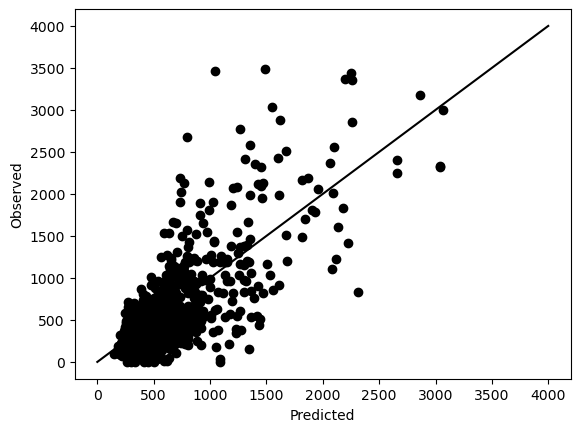

test data correlation coefficient is: 0.7368635245632212
train data correlation coefficient is: 0.9390828016116401


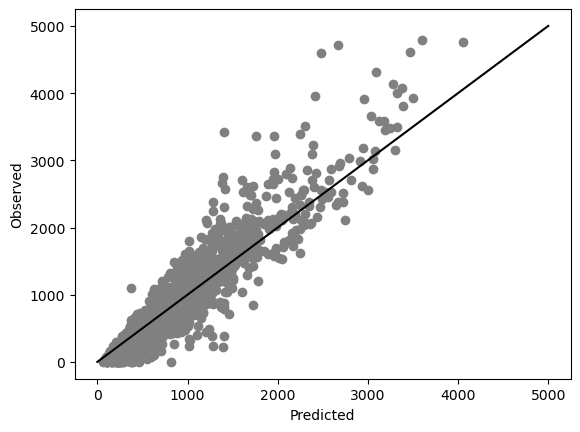

In [37]:
plt.scatter(y_pred, yargs_test, color = 'black') ##label axes - x,y in order?
# plt.plot(X_val, regressor.predict(X_val), color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 4000], [0, 4000], 'k-')
plt.show()

print('test data correlation coefficient is: ' + str(np.corrcoef(yargs_test, y_pred)[0, 1]))

train_pred = pipe.predict(xargs_train) ##Not sure if this is the right thing to do here
plt.scatter(train_pred, yargs_train, color = 'gray')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 5000], [0, 5000], 'k-')
plt.show

print('train data correlation coefficient is: ' + str(np.corrcoef(train_pred, yargs_train)[0, 1]))

In [38]:
##k-fold cross validation; random forest

#Predictors below are based on feature selection - most important variables

predictors = xargs

targets = yargs

from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import KFold, cross_validate

X, y = predictors, targets
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True)

model = pipe
scoring=('r2', 'neg_root_mean_squared_error')

cv_results = cross_validate(model, X, y, cv=kf, scoring=scoring, return_train_score=False)
cv_results

{'fit_time': array([12.18002105, 11.90633917, 11.82902837, 11.92203617, 12.17189097,
        12.05838203, 11.82897806, 12.70985818, 12.5613389 , 12.44571972]),
 'score_time': array([0.03122854, 0.03124356, 0.03073835, 0.03126502, 0.03124356,
        0.01972413, 0.03123164, 0.02826333, 0.02664113, 0.0273726 ]),
 'test_r2': array([0.55535799, 0.58625748, 0.51374786, 0.53578496, 0.55611118,
        0.61502579, 0.48046353, 0.55177206, 0.51509725, 0.58318695]),
 'test_neg_root_mean_squared_error': array([-379.13410967, -405.70257692, -403.52626201, -411.37807183,
        -449.23957648, -414.66923795, -398.12593164, -430.23237545,
        -399.63046113, -398.64783258])}

In [24]:
#Feature importance and average RMSE
x = pd.DataFrame(cv_results)
print(x['test_r2'].mean())
print(x['test_neg_root_mean_squared_error'].mean())
print('NRMSE is: ' + str(x['test_neg_root_mean_squared_error'].mean()/np.ptp(yargs_test)))

0.5638911696715063
-402.35378041940834
NRMSE is: -0.11556868981620869


In [25]:
##Feature selection
import time
import numpy as np

feature_importances = pipe.named_steps['forest'].feature_importances_
feature_importance_df = pd.DataFrame({'Feature': xargs.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df.head(21))  # Keep the top 20 most important features
xx = feature_importance_df.head(21)

# with(pd.set_option('display.max_rows', None) print(xx))

feature_importance_df

                      Feature  Importance
3            Percent_flooding    0.171143
1                      z_star    0.154660
20                      slope    0.109747
16            dayl_daymMarMay    0.071058
9   nd_swir2_nir_median_08_10    0.059594
4                   srad_peak    0.047352
18     nd_swir2_nir_min_05_10    0.042803
0   nd_swir2_nir_median_05_10    0.040123
10       nd_swir2_r_min_05_10    0.034281
17                     eddi2y    0.033480
5              evi_mean_08_10    0.024147
12        nd_g_b_median_01_12    0.024095
14  nd_swir2_nir_median_01_12    0.024033
2     nd_swir2_nir_mean_05_10    0.023923
7           nd_g_b_mean_01_12    0.023490
19            savi_mean_01_12    0.022441
15         Red_band_max_05_10    0.020402
6               evi_max_05_10    0.019640
11             evi_mean_01_12    0.019118
13        Blue_band_max_05_10    0.017606
8               evi_max_01_12    0.016865


,Feature,Importance
3,Percent_flooding,0.171143
1,z_star,0.154660
20,slope,0.109747
16,dayl_daymMarMay,0.071058
9,nd_swir2_nir_median_08_10,0.059594
4,srad_peak,0.047352
18,nd_swir2_nir_min_05_10,0.042803
0,nd_swir2_nir_median_05_10,0.040123
10,nd_swir2_r_min_05_10,0.034281
17,eddi2y,0.033480


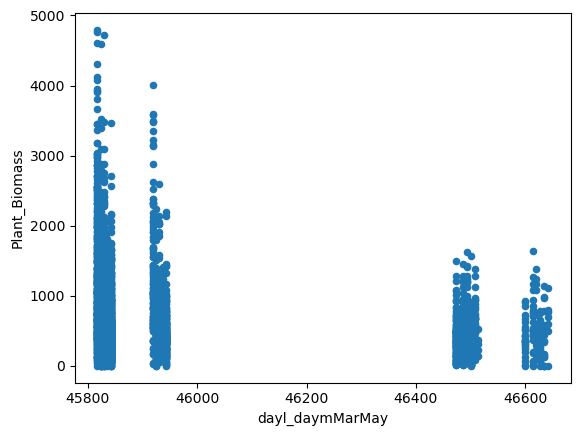

In [46]:
g = df0.plot(kind = 'scatter', x = 'dayl_daymMarMay', y = 'Plant_Biomass')

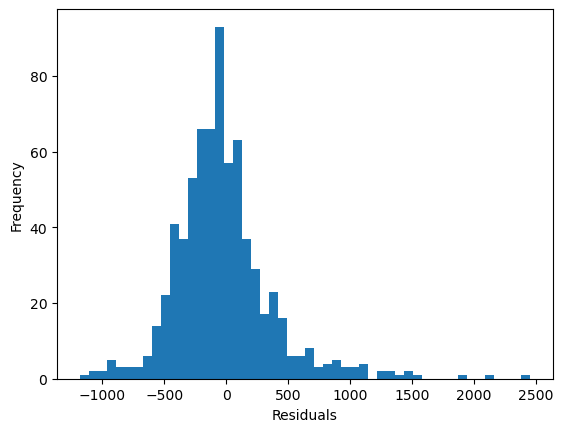

In [33]:
import matplotlib.pyplot as plt
residuals = yargs_test - y_pred
plt.hist(residuals, bins=50)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

In [34]:
# from sklearn.model_selection import RandomizedSearchCV

# param_grid = {
#     'forest__n_estimators': [50, 100, 200, 300, 500, 1000],
#     'forest__max_depth': [10, 20, 30, None],
#     'forest__min_samples_split': [2, 5, 10],
#     'forest__min_samples_leaf': [1, 2, 4]
# }

# rf_search = RandomizedSearchCV(pipe, param_distributions=param_grid, n_iter=50, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=seed)
# rf_search.fit(xargs_train, yargs_train)

# print("Best Params:", rf_search.best_params_)
# pipe = rf_search.best_estimator_

Best Params: {'forest__n_estimators': 300, 'forest__min_samples_split': 5, 'forest__min_samples_leaf': 2, 'forest__max_depth': None}
